# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-darkgrid')

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Importing Data

<h2 style="text-align: center;"> Dataset Feature Description </h2>

Columns | Description  
--------|------------  
Date    |    Date of observation  
Year    |    Experiment year  
Experiment    |    Experiment serial  
DataUse    |    Experiment usage  
Replication    |    Replication serial  
Month    |    Month of experiment  
Vegetation    |    Type of vegetation: Corn, GLYMX (Soyabean), TRIAE (Wheat)  
N2O    |    N2O flux rate **(target)**  
N_rate    |    Nitrogen rate  
PP2    |    Cumilative precipitation (2 days)  
PP7    |    Cumilative precipitation (7 days)  
AirT    |    Mean daily air temperature  
DAF_TD    |    Days after fertilization (Total)
DAF_SD    |    Days after fertilization
WFPS25cm    |    water filled pore space at field capacity (25CM) 
NH4    |    Ammonium content 
NO3    |    Nitrate content 
Sand    |    Desc1 
SOM    |    Soil Organic Matter  
  

In [5]:
filepath = "/kaggle/input/predictions-of-agricultural-nitrous-oxide-emission/Saha_et_al_2020_ERL_Data.xlsx"
try:
    soil_data = pd.read_excel(filepath, sheet_name=1)
except:
    !pip install openpyxl --quiet
    soil_data = pd.read_excel(filepath, sheet_name=1)
soil_data

Date  Year Experiment   DataUse Replication     Month Vegetation  \
0    2012-02-09  2012   BCSE_KBS  Building          R1  February       Corn   
1    2012-02-10  2012   BCSE_KBS  Building          R1  February       Corn   
2    2012-02-18  2012   BCSE_KBS  Building          R1  February       Corn   
3    2012-02-19  2012   BCSE_KBS  Building          R1  February       Corn   
4    2012-03-16  2012   BCSE_KBS  Building          R1     March       Corn   
...         ...   ...        ...       ...         ...       ...        ...   
2241 2013-10-16  2013    MCSE-T2   Testing          R4   October      TRIAE   
2242 2013-11-15  2013    MCSE-T2   Testing          R1  November      TRIAE   
2243 2013-11-15  2013    MCSE-T2   Testing          R2  November      TRIAE   
2244 2013-11-15  2013    MCSE-T2   Testing          R3  November      TRIAE   
2245 2013-11-15  2013    MCSE-T2   Testing          R4  November      TRIAE   

     VegType       N2O  N_rate  ...   PP7   AirT  DAF_TD  DAF_SD  WFPS25cm  \
0     Annual  3.896742     170  ...  0.00  -2.00     276     241  0.666508   
1     Annual  2.190218     170  ...  0.00  -2.40     277     242  0.640608   
2     Annual  3.542594     170  ...  8.64   0.30     285     250  0.728085   
3     Annual  3.342870     170  ...  8.13  -3.80     286     251  0.686872   
4     Annual  2.947778     170  ...  8.39  17.60     312     277  0.716221   
...      ...       ...     ...  ...   ...    ...     ...     ...       ...   
2241  Annual  1.640000      91  ...  8.13  10.81     167     167  0.390203   
2242  Annual  0.990000      91  ...  8.13   5.64     197     197  0.317040   
2243  Annual -0.200000      91  ...  8.13   5.64     197     197  0.341428   
2244  Annual  0.300000      91  ...  8.13   5.64     197     197  0.365815   
2245  Annual  0.400000      91  ...  8.13   5.64     197     197  0.341428   

            NH4        NO3        Clay        Sand       SOM  
0     11.046340  22.940812   62.500000  637.500000  1.174072  
1     11.008087  22.959578   62.500000  637.500000  1.174072  
2     10.831669  23.221928   62.500000  637.500000  1.174072  
3     10.849792  23.271978   62.500000  637.500000  1.174072  
4     10.204748  24.206855   62.500000  637.500000  1.174072  
...         ...        ...         ...         ...       ...  
2241  17.061793   5.803681  128.333333  491.666667  1.806000  
2242   5.624730   5.429873  162.500000  490.375000  1.496400  
2243   3.504328   7.239000  183.250000  432.875000  1.186800  
2244   3.636931   8.434294  169.833333  418.833333  1.823200  
2245   7.376583   6.645088  128.333333  491.666667  1.806000  

[2246 rows x 21 columns]

# EDA

***look for the data size, distribution, null values and statistics to get an idea of attributes***

In [6]:
soil_data.shape

(2246, 21)

In [7]:
soil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2246 non-null   datetime64[ns]
 1   Year         2246 non-null   int64         
 2   Experiment   2246 non-null   object        
 3   DataUse      2246 non-null   object        
 4   Replication  2246 non-null   object        
 5   Month        2246 non-null   object        
 6   Vegetation   2246 non-null   object        
 7   VegType      2246 non-null   object        
 8   N2O          2246 non-null   float64       
 9   N_rate       2246 non-null   int64         
 10  PP2          2246 non-null   float64       
 11  PP7          2246 non-null   float64       
 12  AirT         2246 non-null   float64       
 13  DAF_TD       2246 non-null   int64         
 14  DAF_SD       2246 non-null   int64         
 15  WFPS25cm     2194 non-null   float64       
 16  NH4   

In [8]:
soil_data.describe()

Year          N2O       N_rate          PP2          PP7  \
count  2246.000000  2246.000000  2246.000000  2246.000000  2246.000000   
mean   2011.925200     7.468610   142.994212     5.219839    19.245273   
std       3.617418    28.488257    56.130412    10.064123    23.723416   
min    2002.000000    -7.415297     0.000000     0.000000     0.000000   
25%    2011.000000     0.504316   135.000000     0.000000     3.560000   
50%    2013.000000     1.972058   170.000000     0.510000    11.930000   
75%    2014.000000     5.187618   170.000000     6.000000    27.000000   
max    2017.000000   593.072000   213.000000    95.250000   260.090000   

              AirT       DAF_TD       DAF_SD     WFPS25cm          NH4  \
count  2246.000000  2246.000000  2246.000000  2194.000000  2170.000000   
mean     12.408699   195.321015   198.898041     0.531047    11.451364   
std       9.490152   144.915448   142.907436     0.171868    13.214895   
min     -20.700000     1.000000     0.000000     0.024388     1.383393   
25%       5.940000    73.250000    75.000000     0.390203     5.290323   
50%      14.490000   160.000000   172.000000     0.553853     9.081282   
75%      20.070000   308.750000   320.000000     0.680321    12.140325   
max      30.700000   718.000000   678.000000     0.912113   228.525000   

               NO3         Clay         Sand          SOM  
count  2216.000000  2246.000000  2246.000000  2246.000000  
mean     24.997063   134.425163   462.686739     1.901503  
std      24.941785    79.564891   219.451957     1.132896  
min       0.370070    62.500000    55.000000     1.174072  
25%      10.184722    62.500000   418.833333     1.174072  
50%      19.795863   128.333333   491.666667     1.186800  
75%      27.085459   183.250000   637.500000     1.823200  
max     238.920000   280.000000   637.500000     4.500000

In [9]:
soil_data.isna().sum()

Date            0
Year            0
Experiment      0
DataUse         0
Replication     0
Month           0
Vegetation      0
VegType         0
N2O             0
N_rate          0
PP2             0
PP7             0
AirT            0
DAF_TD          0
DAF_SD          0
WFPS25cm       52
NH4            76
NO3            30
Clay            0
Sand            0
SOM             0
dtype: int64

In [10]:
soil_data.nunique()

Date           1287
Year             15
Experiment        3
DataUse           2
Replication       5
Month            12
Vegetation        3
VegType           1
N2O            1846
N_rate           16
PP2             224
PP7             470
AirT            601
DAF_TD          424
DAF_SD          415
WFPS25cm       1577
NH4            2138
NO3            2192
Clay             10
Sand              9
SOM              11
dtype: int64

### Univariate Analysis

*Checking Target **(N2O)** distribution*

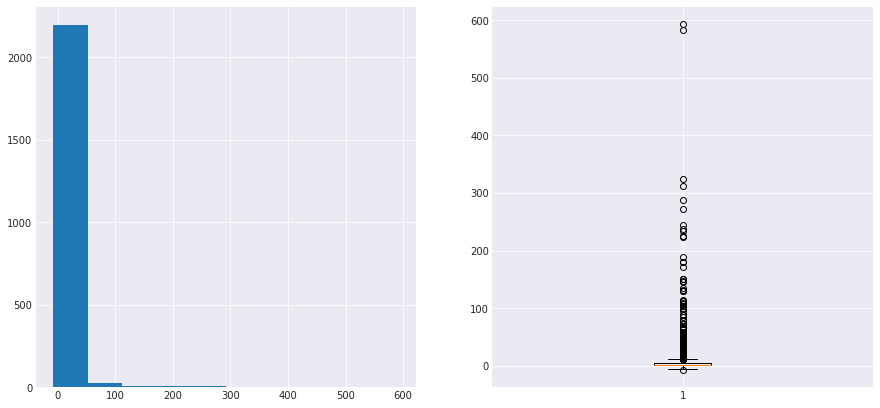

In [11]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = soil_data["N2O"]
ax1.hist(x)
ax2.boxplot(x);

Checking Density plots for numerical attributes

In [12]:
unpivot = pd.melt(soil_data, soil_data.describe().columns[1], soil_data.describe().columns[2:])

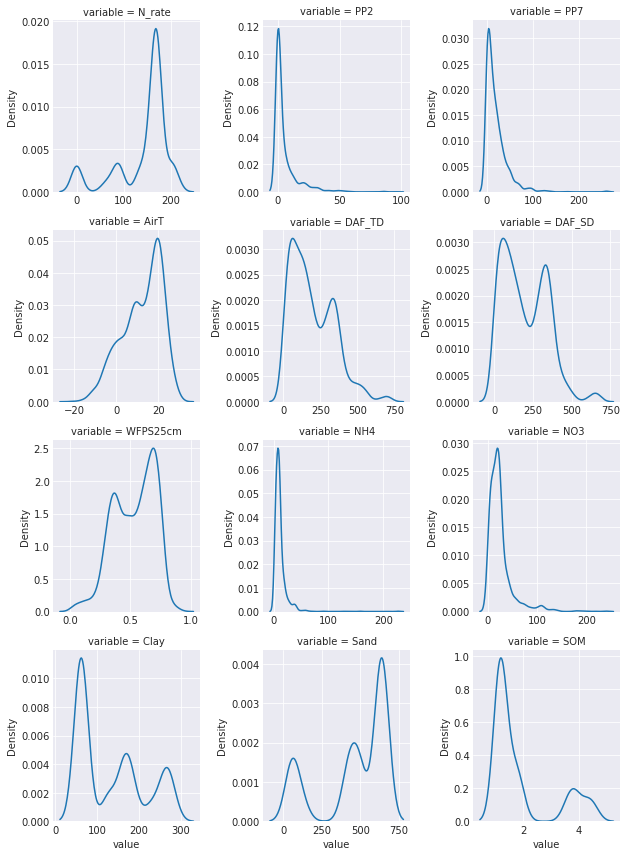

In [13]:
unpivot = pd.melt(soil_data, soil_data.describe().columns[1], soil_data.describe().columns[2:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

Checking boxplot for outlier analysis

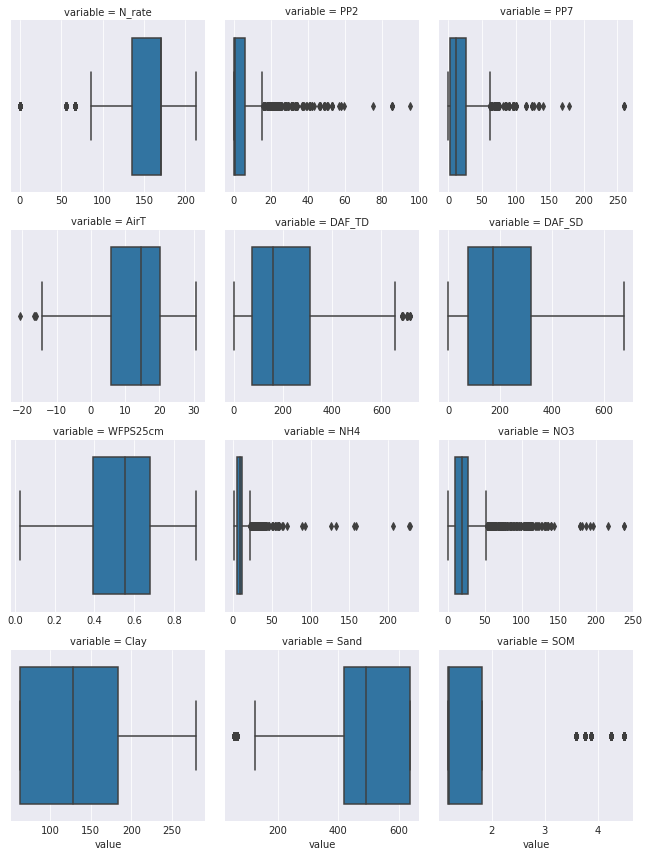

In [14]:
unpivot = pd.melt(soil_data, soil_data.describe().columns[1], soil_data.describe().columns[2:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

***for WFPS, the mean value can be substituted within the quartile range***

In [15]:
soil_data["WFPS25cm"].fillna(soil_data["WFPS25cm"].mean(), inplace=True)
soil_data.fillna(soil_data.mean(), inplace=True)

### Multivariate Analysis

<AxesSubplot:>

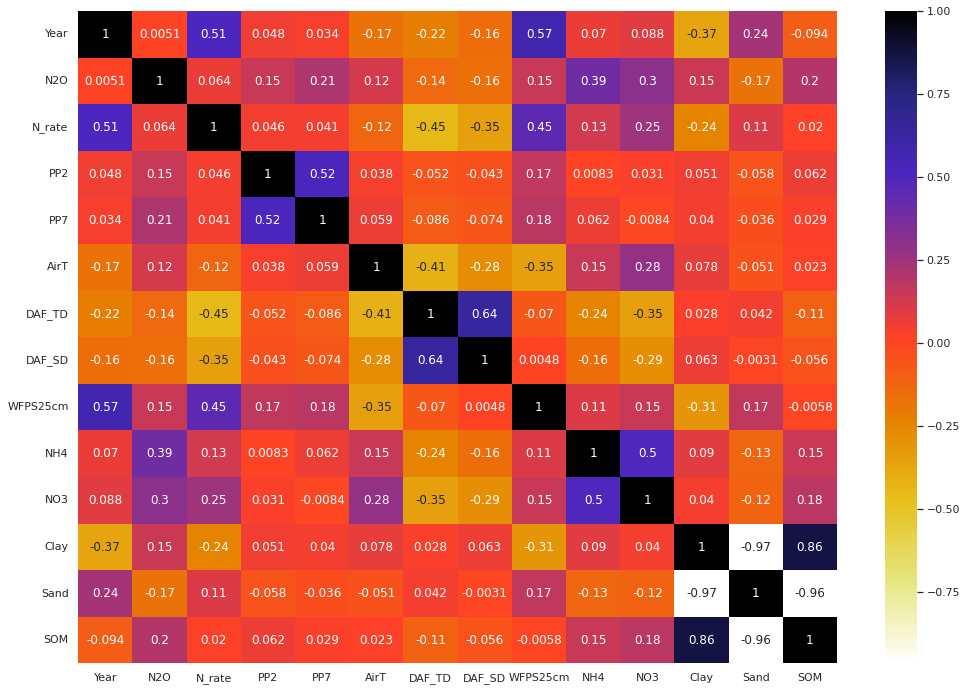

In [16]:
plt.figure(figsize=(17,12))
sns.set()
sns.heatmap(soil_data.corr(), annot=True, cmap=plt.cm.CMRmap_r)

<hr>

**Sand** has high correlation with **SOM** and **Clay**, hence the data linearity will be affected if it is not dropped

The following pairplot shows distribution of Different Crops within the pair-plots of every two columns

<Figure size 1440x864 with 0 Axes>

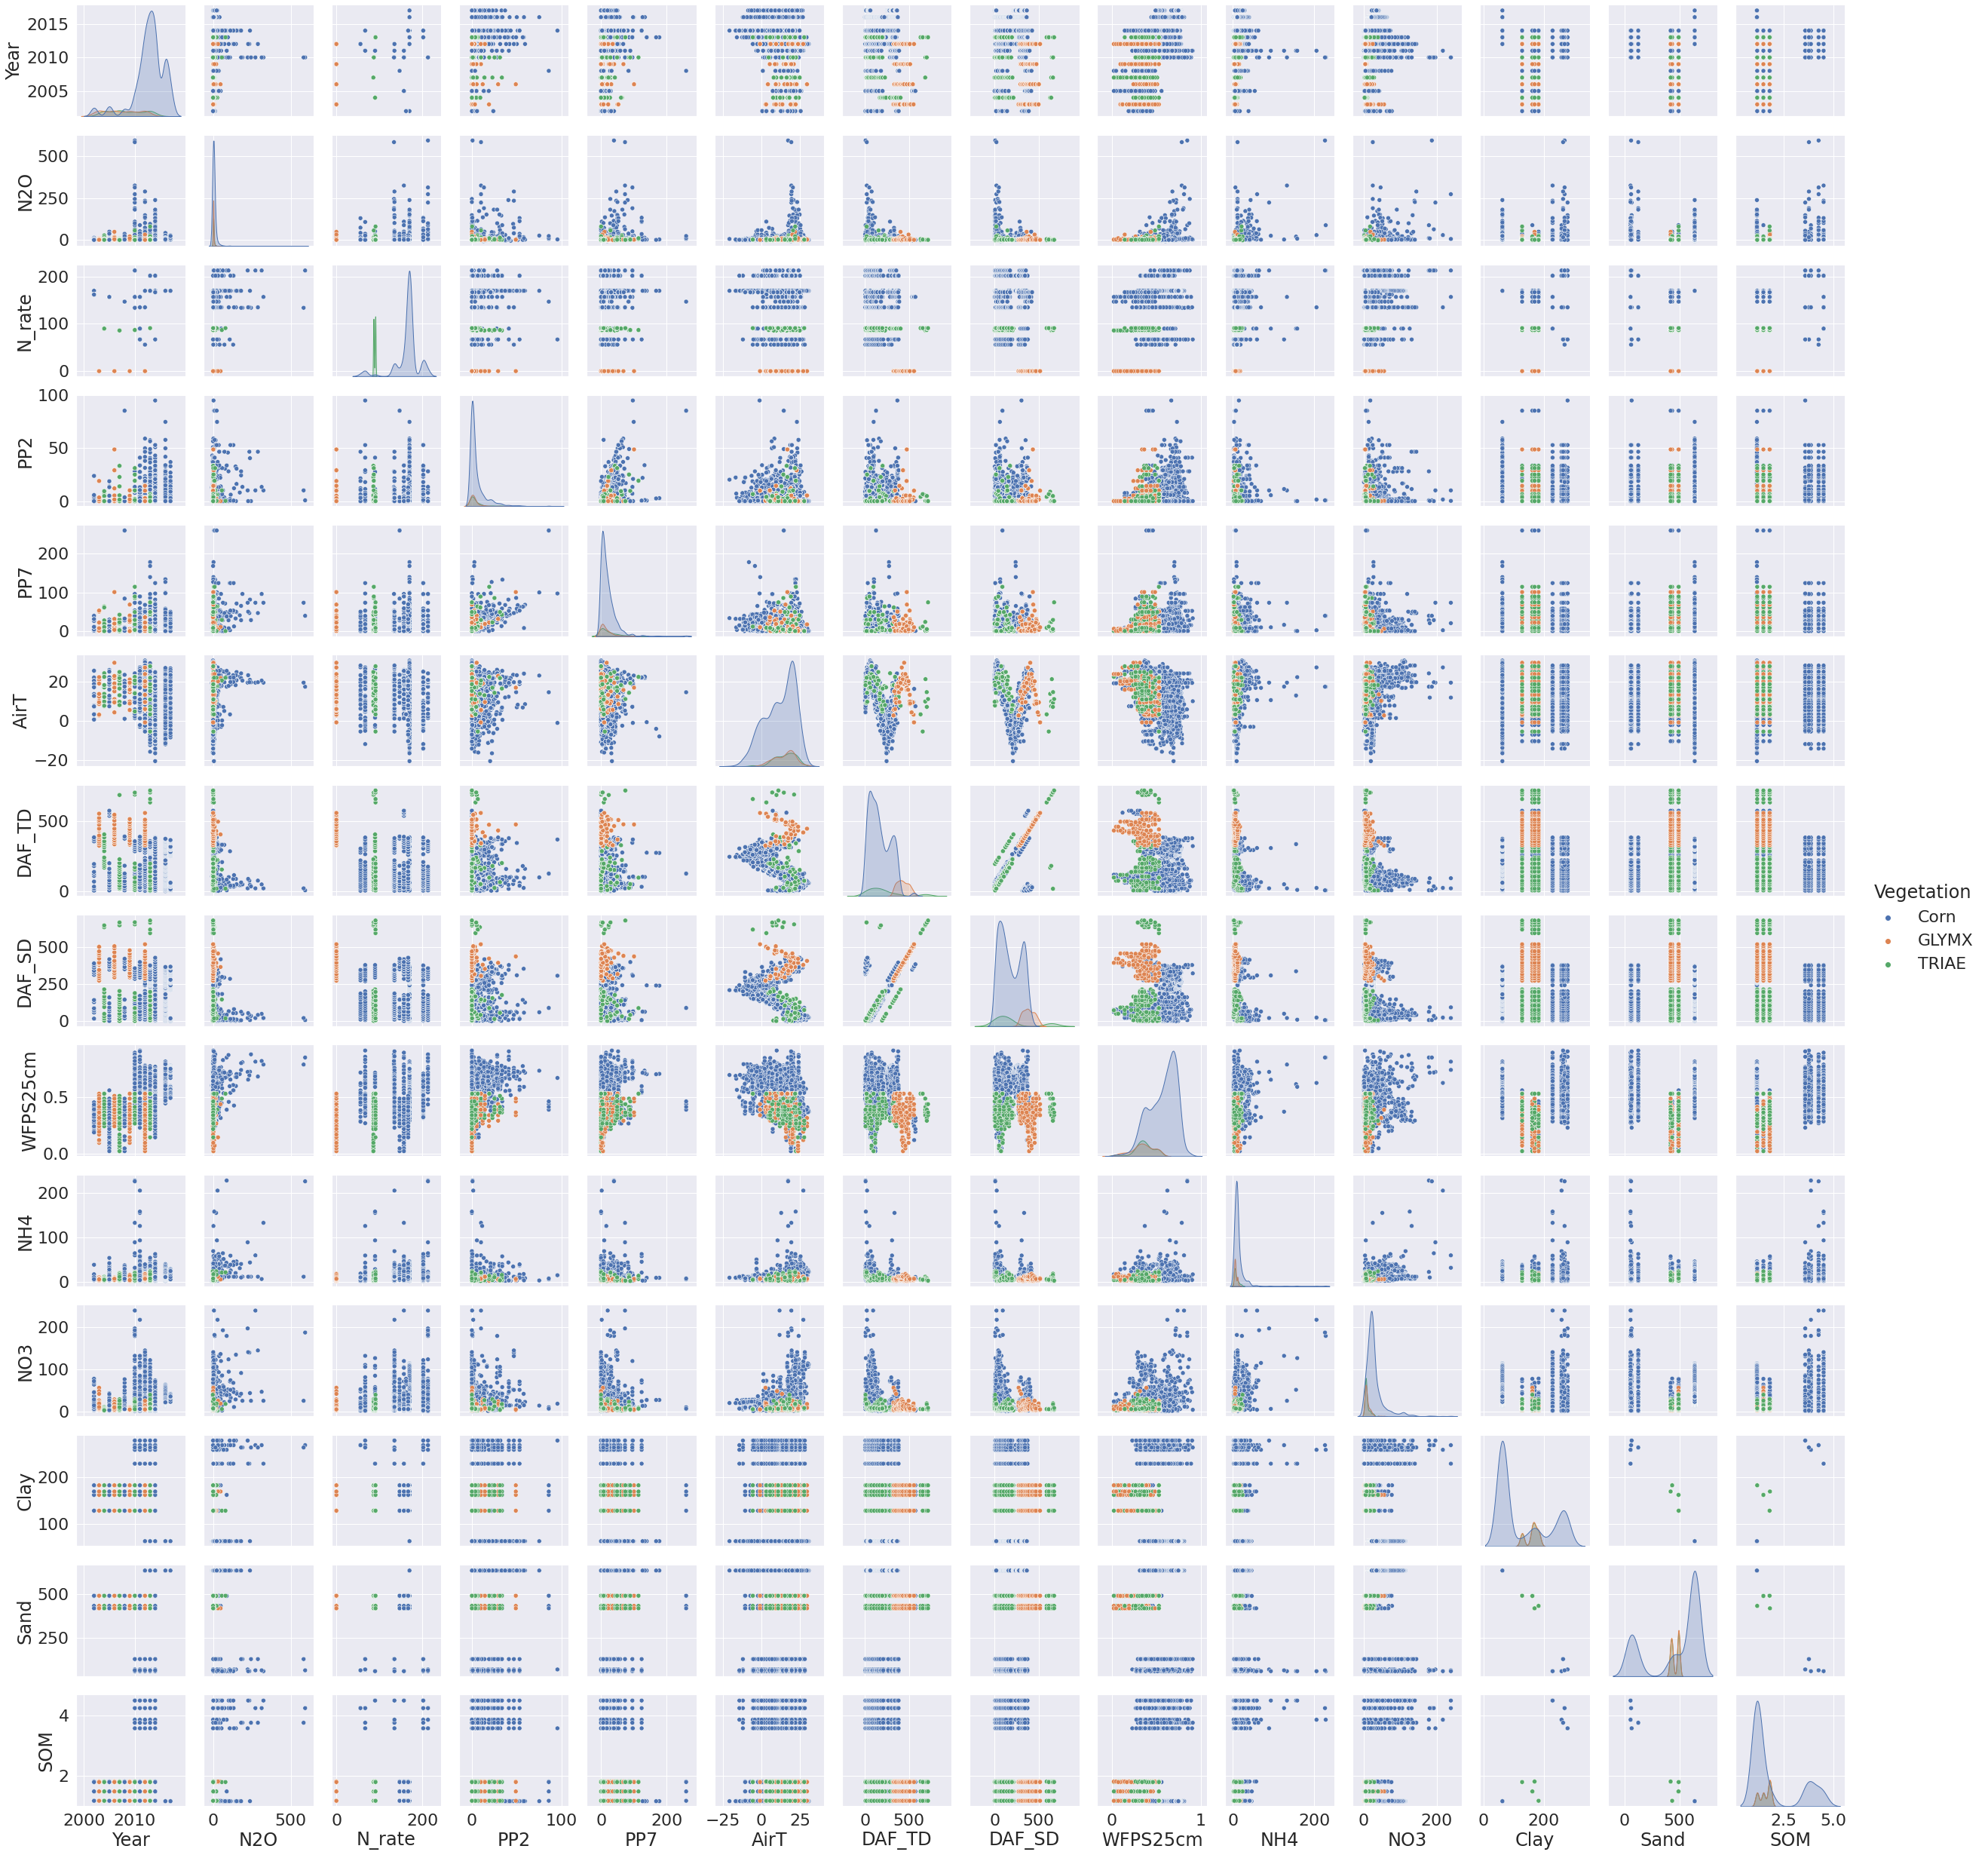

In [25]:
plt.figure(figsize=(20,12));
sns.set(font_scale=2)
sns.pairplot(soil_data, hue="Vegetation", diag_kind='kde');

<hr>

We can perform time-range analysis of the target feature to get the idea of **varying flux** on *different phases of year/month*

**Flux vs Year**

<AxesSubplot:xlabel='Year', ylabel='N2O'>

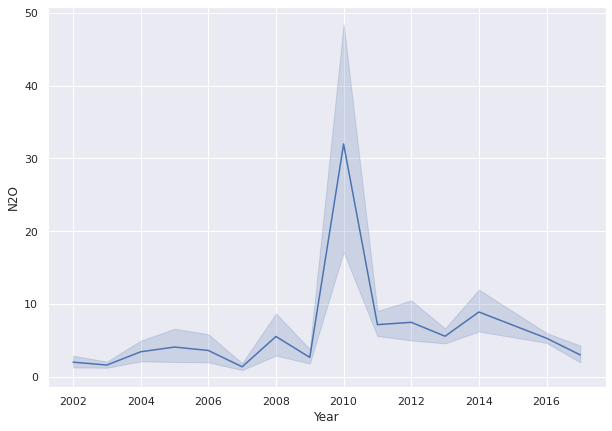

In [26]:
plt.figure(figsize=(10,7))
sns.set()
sns.lineplot(x=soil_data["Year"], y=soil_data["N2O"])

**Flux vs Month**

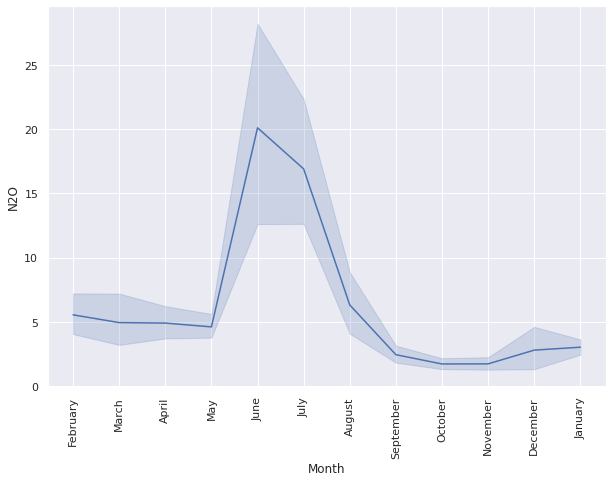

In [27]:
plt.figure(figsize=(10,7))
sns.set()
sns.lineplot(x=soil_data["Month"], y=soil_data["N2O"])
plt.xticks(rotation = 90);

### Domain Analysis

The following sample shows that, everyday there are 4-5 chambers of Flux Monitoring, with respective soil conditions. These chambers are Replications R1-R5.
Also, the VegType has singular unique value, which becomes irrelevant for the dataset (drop).
Experiment serial number are arbitrary for the soil conditions, hence it would be removed.

in conclusion,   
**columns that can be dropped:** *VegType, Sand, Experiment*

In [28]:
soil_data[soil_data["Vegetation"] == "GLYMX"]

Date  Year Experiment  DataUse Replication      Month Vegetation  \
1845 2003-03-31  2003    MCSE-T2  Testing          R1      March      GLYMX   
1846 2003-03-31  2003    MCSE-T2  Testing          R2      March      GLYMX   
1847 2003-03-31  2003    MCSE-T2  Testing          R3      March      GLYMX   
1848 2003-03-31  2003    MCSE-T2  Testing          R4      March      GLYMX   
1849 2003-04-16  2003    MCSE-T2  Testing          R1      April      GLYMX   
...         ...   ...        ...      ...         ...        ...        ...   
2190 2012-09-27  2012    MCSE-T2  Testing          R4  September      GLYMX   
2191 2012-11-14  2012    MCSE-T2  Testing          R1   November      GLYMX   
2192 2012-11-14  2012    MCSE-T2  Testing          R2   November      GLYMX   
2193 2012-11-14  2012    MCSE-T2  Testing          R3   November      GLYMX   
2194 2012-11-14  2012    MCSE-T2  Testing          R4   November      GLYMX   

     VegType   N2O  N_rate  ...      PP7   AirT  DAF_TD  DAF_SD  WFPS25cm  \
1845  Annual  1.31       0  ...   6.0833   2.64     325     273  0.390203   
1846  Annual  0.00       0  ...   6.0833   2.64     325     273  0.414591   
1847  Annual  0.00       0  ...   6.0833   2.64     325     273  0.463366   
1848  Annual  0.00       0  ...   6.0833   2.64     325     273  0.512141   
1849  Annual  0.38       0  ...   0.0000  10.10     341     289  0.317040   
...      ...   ...     ...  ...      ...    ...     ...     ...       ...   
2190  Annual  0.87       0  ...  21.9900  13.16     510     470  0.531047   
2191  Annual  1.02       0  ...   9.9100  -0.92     558     518  0.390203   
2192  Annual  0.82       0  ...   9.9100  -0.92     558     518  0.341428   
2193  Annual  0.61       0  ...   9.9100  -0.92     558     518  0.390203   
2194  Annual  0.00       0  ...   9.9100  -0.92     558     518  0.438978   

           NH4        NO3        Clay        Sand     SOM  
1845  6.065132  55.881764  162.500000  490.375000  1.4964  
1846  3.406069  17.370778  183.250000  432.875000  1.1868  
1847  6.218464  12.900075  169.833333  418.833333  1.8232  
1848  5.627414  20.604030  128.333333  491.666667  1.8060  
1849  5.583002  47.890171  162.500000  490.375000  1.4964  
...        ...        ...         ...         ...     ...  
2190  6.281420   6.778625  128.333333  491.666667  1.8060  
2191  5.927382   3.071813  162.500000  490.375000  1.4964  
2192  5.853370   4.199581  183.250000  432.875000  1.1868  
2193  8.006792   5.117328  169.833333  418.833333  1.8232  
2194  6.678441   4.543682  128.333333  491.666667  1.8060  

[204 rows x 21 columns]

In [29]:
soil_data.drop(["VegType", "Sand", "Experiment"], axis=1, inplace=True)
soil_data

Date  Year   DataUse Replication     Month Vegetation       N2O  \
0    2012-02-09  2012  Building          R1  February       Corn  3.896742   
1    2012-02-10  2012  Building          R1  February       Corn  2.190218   
2    2012-02-18  2012  Building          R1  February       Corn  3.542594   
3    2012-02-19  2012  Building          R1  February       Corn  3.342870   
4    2012-03-16  2012  Building          R1     March       Corn  2.947778   
...         ...   ...       ...         ...       ...        ...       ...   
2241 2013-10-16  2013   Testing          R4   October      TRIAE  1.640000   
2242 2013-11-15  2013   Testing          R1  November      TRIAE  0.990000   
2243 2013-11-15  2013   Testing          R2  November      TRIAE -0.200000   
2244 2013-11-15  2013   Testing          R3  November      TRIAE  0.300000   
2245 2013-11-15  2013   Testing          R4  November      TRIAE  0.400000   

      N_rate   PP2   PP7   AirT  DAF_TD  DAF_SD  WFPS25cm        NH4  \
0        170  0.00  0.00  -2.00     276     241  0.666508  11.046340   
1        170  0.00  0.00  -2.40     277     242  0.640608  11.008087   
2        170  3.30  8.64   0.30     285     250  0.728085  10.831669   
3        170  0.00  8.13  -3.80     286     251  0.686872  10.849792   
4        170  1.02  8.39  17.60     312     277  0.716221  10.204748   
...      ...   ...   ...    ...     ...     ...       ...        ...   
2241      91  3.81  8.13  10.81     167     167  0.390203  17.061793   
2242      91  0.00  8.13   5.64     197     197  0.317040   5.624730   
2243      91  0.00  8.13   5.64     197     197  0.341428   3.504328   
2244      91  0.00  8.13   5.64     197     197  0.365815   3.636931   
2245      91  0.00  8.13   5.64     197     197  0.341428   7.376583   

            NO3        Clay       SOM  
0     22.940812   62.500000  1.174072  
1     22.959578   62.500000  1.174072  
2     23.221928   62.500000  1.174072  
3     23.271978   62.500000  1.174072  
4     24.206855   62.500000  1.174072  
...         ...         ...       ...  
2241   5.803681  128.333333  1.806000  
2242   5.429873  162.500000  1.496400  
2243   7.239000  183.250000  1.186800  
2244   8.434294  169.833333  1.823200  
2245   6.645088  128.333333  1.806000  

[2246 rows x 18 columns]

### Questions about the dataset arised after domain analysis

Can the replications be merged?    
Do the month have a pattern?    
What is the deviation between building and testing DataUse?   
Can we remove the Date?   
Should we replace NO3 and NH4 with mean or log?   

**to answer them, the further exploration is performed:**

In [30]:
soil_data["DataUse"].value_counts()

Building    1576
Testing      670
Name: DataUse, dtype: int64

In [31]:
soil_data.columns

Index(['Date', 'Year', 'DataUse', 'Replication', 'Month', 'Vegetation', 'N2O',
       'N_rate', 'PP2', 'PP7', 'AirT', 'DAF_TD', 'DAF_SD', 'WFPS25cm', 'NH4',
       'NO3', 'Clay', 'SOM'],
      dtype='object')

<hr>

*exploring chamber conditions with each column value*

<Figure size 1224x864 with 0 Axes>

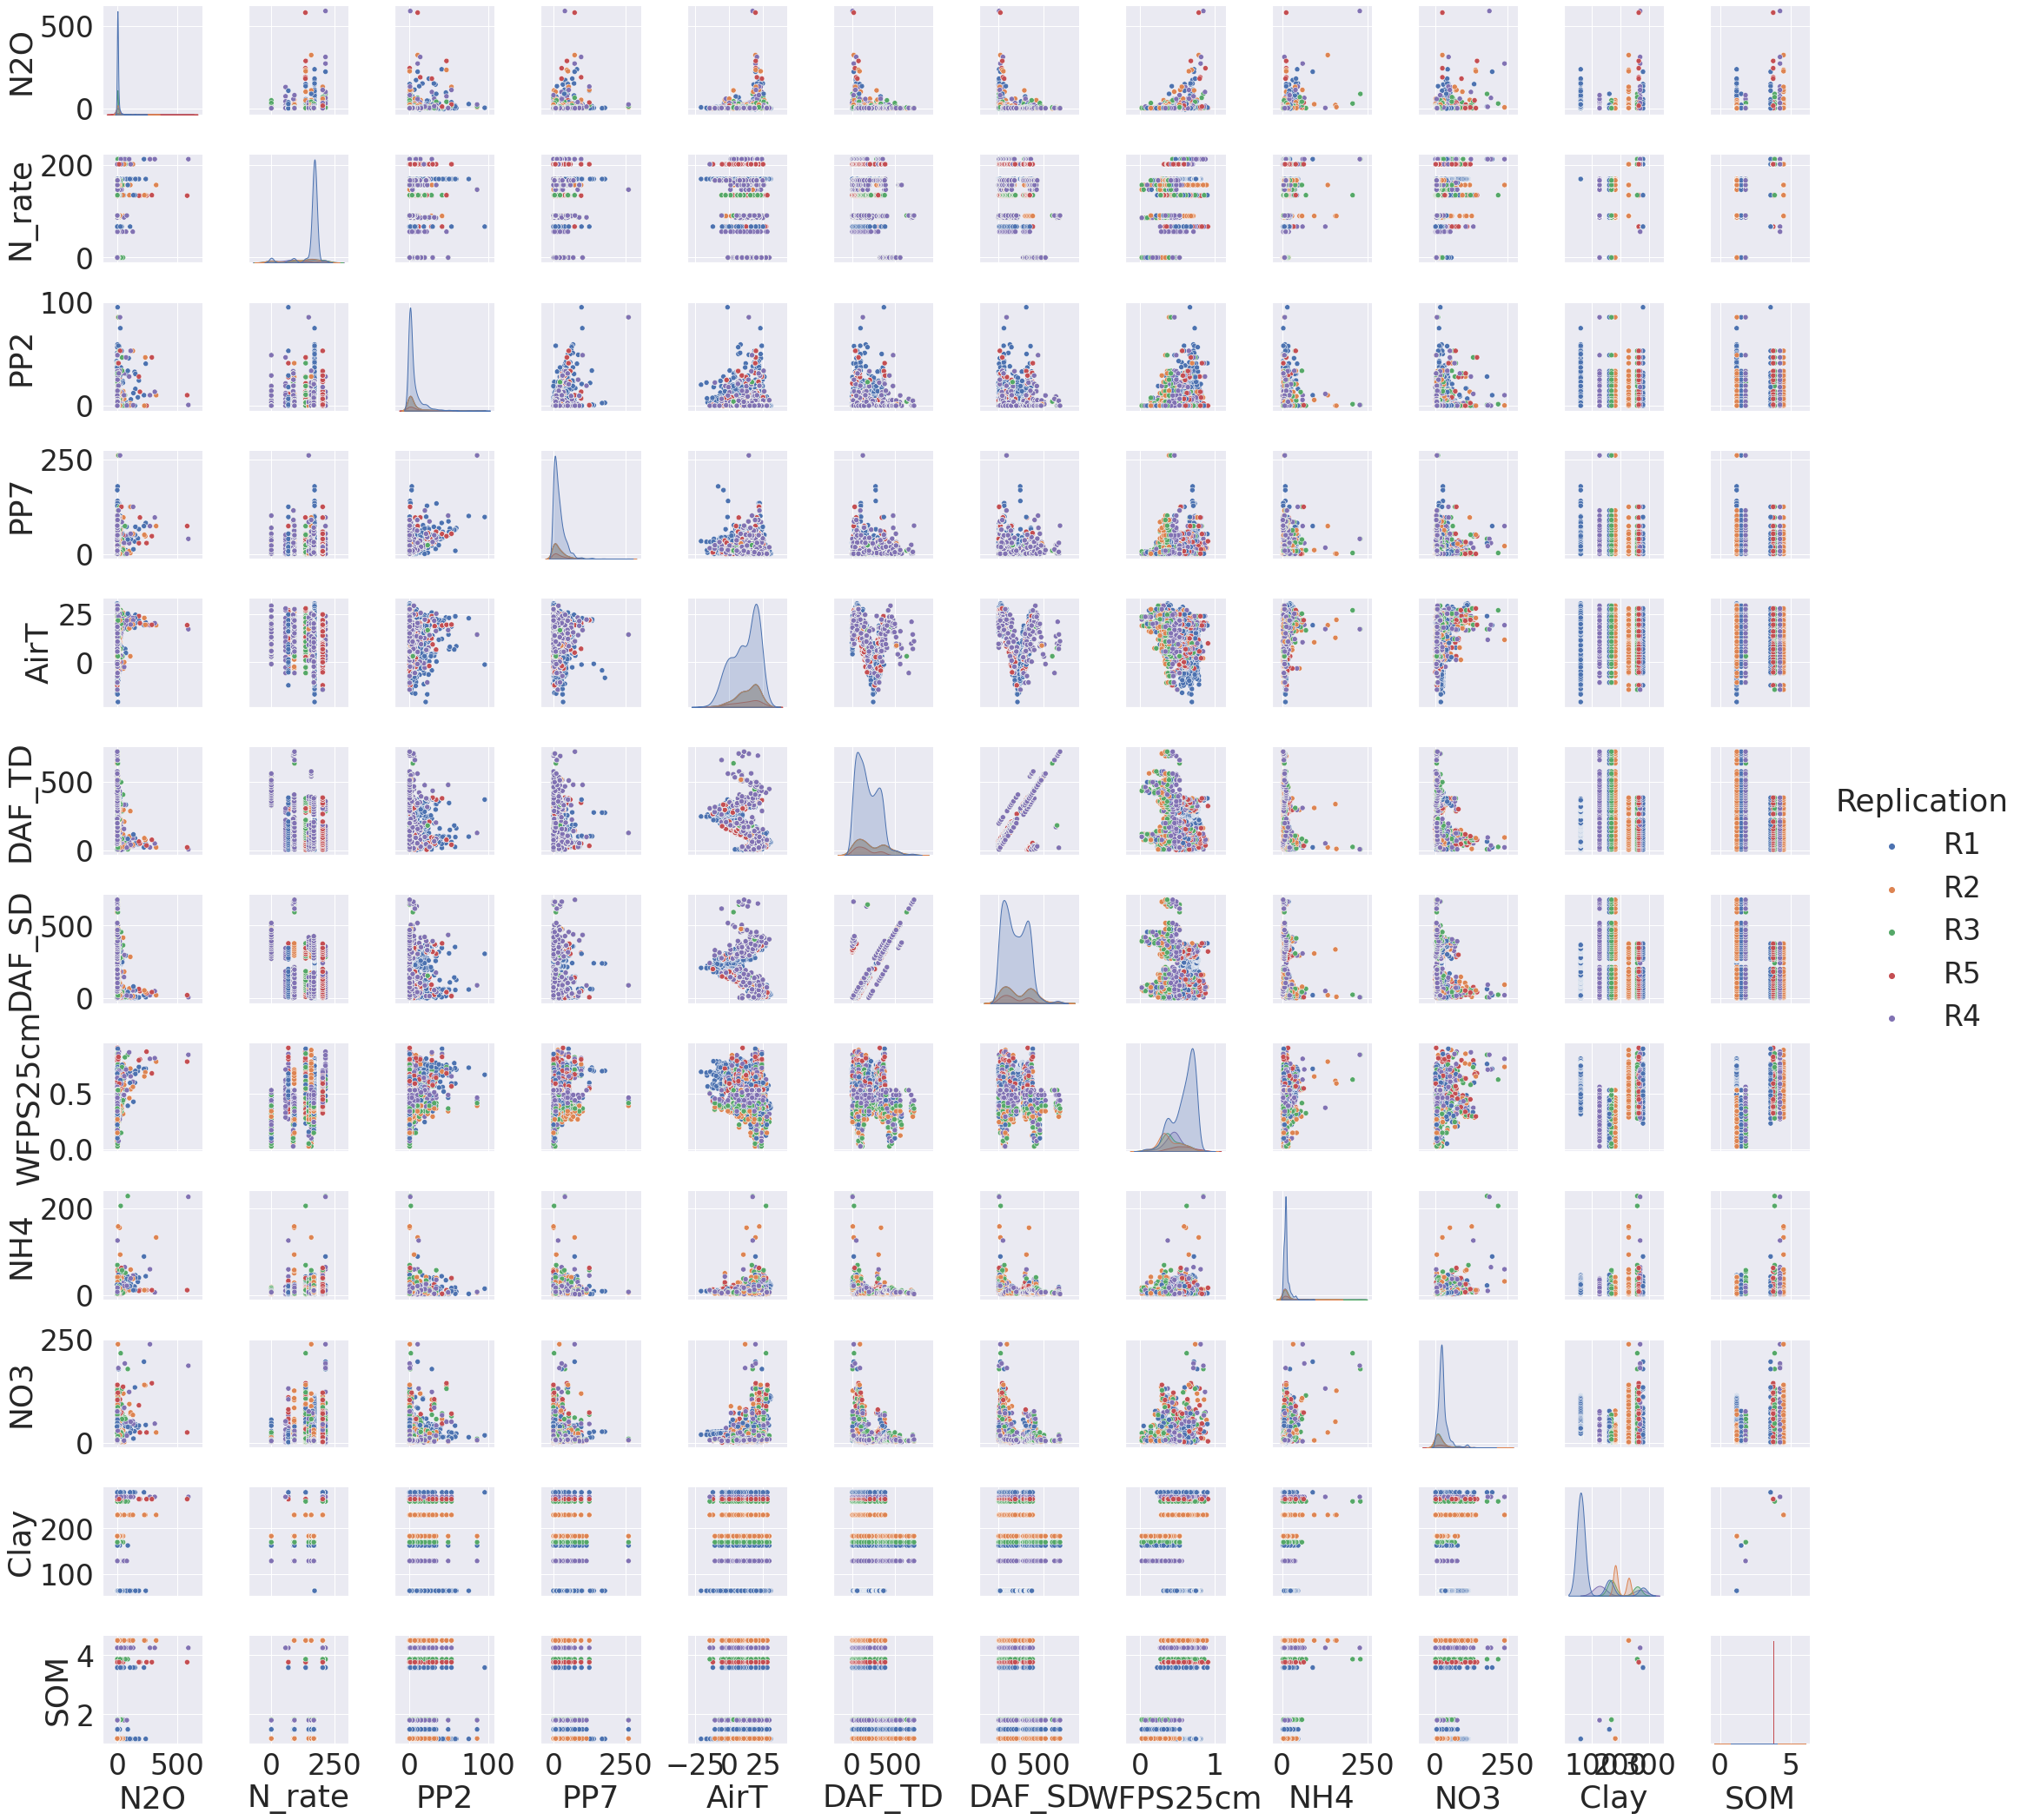

In [32]:
plt.figure(figsize=(17,12))
sns.set(font_scale=3)
sns.pairplot(
soil_data[['Replication', 'N2O', 'N_rate', 'PP2', 'PP7', 'AirT', 'DAF_TD', 'DAF_SD', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'SOM']],
    hue="Replication", diag_kind='kde')

# Preprocessing

### Encoding

In [33]:
months_dict = {'January': 1,
 'February': 2,
 'March': 3,
 'April': 4,
 'May': 5,
 'June': 6,
 'July': 7,
 'August': 8,
 'September': 9,
 'October': 10,
 'November': 11,
 'December': 12}

crops_dict = {"Corn": 1, "GLYMX": 2, "TRIAE": 3}
datause_dict = {"Building": 1, "Testing": 0}


In [34]:
soil_data["Month"] = soil_data["Month"].apply(lambda x: months_dict[x])
soil_data["Vegetation"] = soil_data["Vegetation"].apply(lambda x: crops_dict[x])
soil_data["DataUse"] = soil_data["DataUse"].apply(lambda x: datause_dict[x])

This is the encoded and preprocessed dataset (stage 1). Herewith, there will be 2+ copies for processing and model testing

In [35]:
# soil_data.to_csv("soil_n2o_v0_encoded.csv", index=False)
soil_data

Date  Year  DataUse Replication  Month  Vegetation       N2O  \
0    2012-02-09  2012        1          R1      2           1  3.896742   
1    2012-02-10  2012        1          R1      2           1  2.190218   
2    2012-02-18  2012        1          R1      2           1  3.542594   
3    2012-02-19  2012        1          R1      2           1  3.342870   
4    2012-03-16  2012        1          R1      3           1  2.947778   
...         ...   ...      ...         ...    ...         ...       ...   
2241 2013-10-16  2013        0          R4     10           3  1.640000   
2242 2013-11-15  2013        0          R1     11           3  0.990000   
2243 2013-11-15  2013        0          R2     11           3 -0.200000   
2244 2013-11-15  2013        0          R3     11           3  0.300000   
2245 2013-11-15  2013        0          R4     11           3  0.400000   

      N_rate   PP2   PP7   AirT  DAF_TD  DAF_SD  WFPS25cm        NH4  \
0        170  0.00  0.00  -2.00     276     241  0.666508  11.046340   
1        170  0.00  0.00  -2.40     277     242  0.640608  11.008087   
2        170  3.30  8.64   0.30     285     250  0.728085  10.831669   
3        170  0.00  8.13  -3.80     286     251  0.686872  10.849792   
4        170  1.02  8.39  17.60     312     277  0.716221  10.204748   
...      ...   ...   ...    ...     ...     ...       ...        ...   
2241      91  3.81  8.13  10.81     167     167  0.390203  17.061793   
2242      91  0.00  8.13   5.64     197     197  0.317040   5.624730   
2243      91  0.00  8.13   5.64     197     197  0.341428   3.504328   
2244      91  0.00  8.13   5.64     197     197  0.365815   3.636931   
2245      91  0.00  8.13   5.64     197     197  0.341428   7.376583   

            NO3        Clay       SOM  
0     22.940812   62.500000  1.174072  
1     22.959578   62.500000  1.174072  
2     23.221928   62.500000  1.174072  
3     23.271978   62.500000  1.174072  
4     24.206855   62.500000  1.174072  
...         ...         ...       ...  
2241   5.803681  128.333333  1.806000  
2242   5.429873  162.500000  1.496400  
2243   7.239000  183.250000  1.186800  
2244   8.434294  169.833333  1.823200  
2245   6.645088  128.333333  1.806000  

[2246 rows x 18 columns]

***it is suggested to copy the dataset before further processing, to save checkpoint***

In [36]:
soil_data_copy = soil_data.copy()
# soil_data_copy.drop(["Date"], axis=1, inplace=True)
replica_dict = {"R1": 1, "R2": 2, "R3": 3, "R4": 4, "R5": 5}
soil_data_copy["Replication"] = soil_data_copy["Replication"].apply(lambda x: replica_dict[x])
soil_data_copy

Date  Year  DataUse  Replication  Month  Vegetation       N2O  \
0    2012-02-09  2012        1            1      2           1  3.896742   
1    2012-02-10  2012        1            1      2           1  2.190218   
2    2012-02-18  2012        1            1      2           1  3.542594   
3    2012-02-19  2012        1            1      2           1  3.342870   
4    2012-03-16  2012        1            1      3           1  2.947778   
...         ...   ...      ...          ...    ...         ...       ...   
2241 2013-10-16  2013        0            4     10           3  1.640000   
2242 2013-11-15  2013        0            1     11           3  0.990000   
2243 2013-11-15  2013        0            2     11           3 -0.200000   
2244 2013-11-15  2013        0            3     11           3  0.300000   
2245 2013-11-15  2013        0            4     11           3  0.400000   

      N_rate   PP2   PP7   AirT  DAF_TD  DAF_SD  WFPS25cm        NH4  \
0        170  0.00  0.00  -2.00     276     241  0.666508  11.046340   
1        170  0.00  0.00  -2.40     277     242  0.640608  11.008087   
2        170  3.30  8.64   0.30     285     250  0.728085  10.831669   
3        170  0.00  8.13  -3.80     286     251  0.686872  10.849792   
4        170  1.02  8.39  17.60     312     277  0.716221  10.204748   
...      ...   ...   ...    ...     ...     ...       ...        ...   
2241      91  3.81  8.13  10.81     167     167  0.390203  17.061793   
2242      91  0.00  8.13   5.64     197     197  0.317040   5.624730   
2243      91  0.00  8.13   5.64     197     197  0.341428   3.504328   
2244      91  0.00  8.13   5.64     197     197  0.365815   3.636931   
2245      91  0.00  8.13   5.64     197     197  0.341428   7.376583   

            NO3        Clay       SOM  
0     22.940812   62.500000  1.174072  
1     22.959578   62.500000  1.174072  
2     23.221928   62.500000  1.174072  
3     23.271978   62.500000  1.174072  
4     24.206855   62.500000  1.174072  
...         ...         ...       ...  
2241   5.803681  128.333333  1.806000  
2242   5.429873  162.500000  1.496400  
2243   7.239000  183.250000  1.186800  
2244   8.434294  169.833333  1.823200  
2245   6.645088  128.333333  1.806000  

[2246 rows x 18 columns]

# Scaling

scaling the numerical features below, and then performing baseline modeling

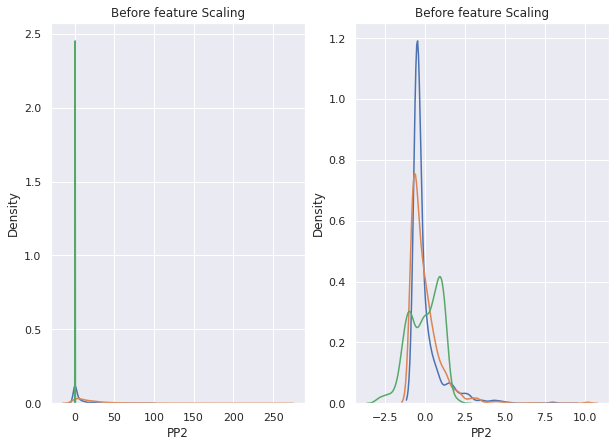

In [39]:
X_sample = soil_data_copy[["N_rate","PP2","PP7","AirT","DAF_TD","DAF_SD","WFPS25cm","NH4","NO3","Clay","SOM"]]
y_sample = soil_data_copy.drop(["N_rate","PP2","PP7","AirT","DAF_TD","DAF_SD","WFPS25cm","NH4","NO3","Clay","SOM"], axis=1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 7))
ax1.set_title('Before feature Scaling')
sns.kdeplot(X_sample["PP2"], ax=ax1)
sns.kdeplot(X_sample["PP7"], ax=ax1)
sns.kdeplot(X_sample["WFPS25cm"], ax=ax1)


sc = StandardScaler()
X_sample_scaled = pd.DataFrame(sc.fit_transform(X_sample), columns=X_sample.columns)

ax2.set_title('Before feature Scaling')
sns.set(font_scale=1)
sns.kdeplot(X_sample_scaled["PP2"], ax=ax2)
sns.kdeplot(X_sample_scaled["PP7"], ax=ax2)
sns.kdeplot(X_sample_scaled["WFPS25cm"], ax=ax2)
plt.show()

<hr>
<hr>

For the daily flux reading, the flux values of different chambers can be **merged into a single value** through mean. hence we take mean by ***date***

In [40]:
scaled_data = pd.concat([X_sample_scaled, y_sample], axis=1)
soil_grp_sc = scaled_data.groupby("Date").mean()

soil_grp_sc

N_rate       PP2       PP7      AirT    DAF_TD    DAF_SD  \
Date                                                                     
2002-03-27  0.481233 -0.518774 -0.811416 -1.249858  1.109024  0.791611   
2002-04-10  0.481233  1.854142  0.275558 -0.499439  1.205654  0.889599   
2002-04-24  0.481233 -0.417798 -0.549578  0.059159  1.302284  0.987586   
2002-05-15  0.374315 -0.518774  0.858669  0.121342 -1.313617  1.134567   
2002-05-30  0.338676 -0.518774 -0.662024  1.010883 -1.210085  1.239553   
...              ...       ...       ...       ...       ...       ...   
2017-07-05  0.481233 -0.518774  0.242630  1.053042 -0.954707 -1.287120   
2017-07-06  0.481233 -0.518774  0.242630  1.168977 -0.947805 -1.280121   
2017-07-07  0.481233  0.375691 -0.347636  1.147898 -0.940903 -1.273122   
2017-07-08  0.481233  0.375691  0.031821  0.779013 -0.934001 -1.266123   
2017-07-09  0.481233  0.375691  0.031821  0.800092 -0.927099 -1.259123   

            WFPS25cm       NH4       NO3      Clay       SOM    Year  DataUse  \
Date                                                                            
2002-03-27 -0.947729 -0.469799 -0.883465  0.333815 -0.285530  2002.0      0.0   
2002-04-10 -0.677234 -0.390684 -0.839041  0.333815 -0.285530  2002.0      0.0   
2002-04-24 -1.157614 -0.347390 -0.840750  0.333815 -0.285530  2002.0      0.0   
2002-05-15 -1.052846 -0.231768 -0.641797  0.333815 -0.285530  2002.0      0.0   
2002-05-30 -1.526328 -0.132096 -0.123178  0.333815 -0.285530  2002.0      0.0   
...              ...       ...       ...       ...       ...     ...      ...   
2017-07-05 -0.037166  0.844516  0.372217 -0.904182 -0.642242  2017.0      1.0   
2017-07-06 -0.112985  0.642479  0.319283 -0.904182 -0.642242  2017.0      1.0   
2017-07-07 -0.162544  0.833101  0.345214 -0.904182 -0.642242  2017.0      1.0   
2017-07-08 -0.180028  0.928324  0.369233 -0.904182 -0.642242  2017.0      1.0   
2017-07-09 -0.223608  0.987867  0.417460 -0.904182 -0.642242  2017.0      1.0   

            Replication  Month  Vegetation        N2O  
Date                                                   
2002-03-27          2.5    3.0         1.0   0.307500  
2002-04-10          2.5    4.0         1.0   0.630000  
2002-04-24          2.5    4.0         1.0   0.610000  
2002-05-15          2.5    5.0         1.0   3.935000  
2002-05-30          2.5    5.0         1.0   1.760000  
...                 ...    ...         ...        ...  
2017-07-05          1.0    7.0         1.0  21.102827  
2017-07-06          1.0    7.0         1.0  22.966965  
2017-07-07          1.0    7.0         1.0  27.918279  
2017-07-08          1.0    7.0         1.0  25.631418  
2017-07-09          1.0    7.0         1.0  22.892078  

[1287 rows x 17 columns]

In [56]:
# This function will return r2 score for any/all of the 3 models mentioned
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        scores['xgb'] = mean_squared_error(y_test, y_pred)
        
    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestRegressor(n_estimators=200, criterion='mse')
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf'] = mean_squared_error(y_test, y_pred)
        models.append(rf)

    if 'dtree' in kwargs.keys() and kwargs['dtree']:
        dtree = DecisionTreeRegressor(criterion='mse')
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)
        scores['dtree'] = mean_squared_error(y_test, y_pred)
        models.append(dtree)
        
    return scores


In [57]:
X_sample = soil_grp_sc.drop("N2O", axis=1)
y_sample = soil_grp_sc["N2O"]

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.33, random_state=101)

modelling(X_train, y_train, X_test, y_test, xgb=True, rf=True, dtree=True)



{'xgb': 302.04307189962856,
 'rf': 241.1336833846725,
 'dtree': 392.5052498522928}

The initial scores are still low on scaling. Also, the outliers are a part of actual readings of the chamber environment, which would lose authenticity if scaled. for the 2nd approach, the data would be considered raw and unscaled as shown below.

***Note***: *Scaling approach is as viable as non-scaled approach. Hence, you can go with either*

<hr>
<hr>
<hr>
<hr>
<hr>

# Without Scaling

In [58]:
soil_group = soil_data.groupby("Date").mean()
soil_group

Year  DataUse  Month  Vegetation        N2O  N_rate     PP2  \
Date                                                                        
2002-03-27  2002.0      0.0    3.0         1.0   0.307500   170.0   0.000   
2002-04-10  2002.0      0.0    4.0         1.0   0.630000   170.0  23.876   
2002-04-24  2002.0      0.0    4.0         1.0   0.610000   170.0   1.016   
2002-05-15  2002.0      0.0    5.0         1.0   3.935000   164.0   0.000   
2002-05-30  2002.0      0.0    5.0         1.0   1.760000   162.0   0.000   
...            ...      ...    ...         ...        ...     ...     ...   
2017-07-05  2017.0      1.0    7.0         1.0  21.102827   170.0   0.000   
2017-07-06  2017.0      1.0    7.0         1.0  22.966965   170.0   0.000   
2017-07-07  2017.0      1.0    7.0         1.0  27.918279   170.0   9.000   
2017-07-08  2017.0      1.0    7.0         1.0  25.631418   170.0   9.000   
2017-07-09  2017.0      1.0    7.0         1.0  22.892078   170.0   9.000   

                PP7   AirT  DAF_TD  DAF_SD  WFPS25cm        NH4        NO3  \
Date                                                                         
2002-03-27   0.0000   0.55   356.0   312.0  0.370097   5.350371   3.114477   
2002-04-10  25.7810   7.67   370.0   326.0  0.416034   6.377781   4.214812   
2002-04-24   6.2103  12.97   384.0   340.0  0.334452   6.940021   4.172479   
2002-05-15  39.6113  13.56     5.0   361.0  0.352245   8.441531   9.100344   
2002-05-30   3.5433  22.00    20.0   376.0  0.271834   9.735911  21.946054   
...             ...    ...     ...     ...       ...        ...        ...   
2017-07-05  25.0000  22.40    57.0    15.0  0.524735  22.418589  34.216524   
2017-07-06  25.0000  23.50    58.0    16.0  0.511859  19.794852  32.905413   
2017-07-07  11.0000  23.30    59.0    17.0  0.503443  22.270345  33.547679   
2017-07-08  20.0000  19.80    60.0    18.0  0.500473  23.506947  34.142608   
2017-07-09  20.0000  20.00    61.0    19.0  0.493072  24.280197  35.337144   

                  Clay       SOM  
Date                              
2002-03-27  160.979167  1.578100  
2002-04-10  160.979167  1.578100  
2002-04-24  160.979167  1.578100  
2002-05-15  160.979167  1.578100  
2002-05-30  160.979167  1.578100  
...                ...       ...  
2017-07-05   62.500000  1.174072  
2017-07-06   62.500000  1.174072  
2017-07-07   62.500000  1.174072  
2017-07-08   62.500000  1.174072  
2017-07-09   62.500000  1.174072  

[1287 rows x 16 columns]

In [59]:
soil_group.DataUse.value_counts()

1.000000    1115
0.000000     136
0.200000      32
0.555556       3
0.250000       1
Name: DataUse, dtype: int64

In [60]:
soil_group["DataUse"].apply(lambda x: round(x))

Date
2002-03-27    0
2002-04-10    0
2002-04-24    0
2002-05-15    0
2002-05-30    0
             ..
2017-07-05    1
2017-07-06    1
2017-07-07    1
2017-07-08    1
2017-07-09    1
Name: DataUse, Length: 1287, dtype: int64

In [61]:
soil_group.Vegetation.value_counts()

1.000000    1183
2.000000      43
3.000000      39
2.600000      10
1.800000       9
1.888889       1
1.444444       1
2.500000       1
Name: Vegetation, dtype: int64

In [62]:
soil_group["Vegetation"] = soil_group["Vegetation"].apply(lambda x: round(x))

In [63]:
soil_group["Vegetation"].value_counts()

1    1184
2      54
3      49
Name: Vegetation, dtype: int64

Vegetation count for each crop before flux mean:

In [64]:
soil_data.groupby("Vegetation").count()

Date  Year  DataUse  Replication  Month   N2O  N_rate   PP2   PP7  \
Vegetation                                                                      
1           1845  1845     1845         1845   1845  1845    1845  1845  1845   
2            204   204      204          204    204   204     204   204   204   
3            197   197      197          197    197   197     197   197   197   

            AirT  DAF_TD  DAF_SD  WFPS25cm   NH4   NO3  Clay   SOM  
Vegetation                                                          
1           1845    1845    1845      1845  1845  1845  1845  1845  
2            204     204     204       204   204   204   204   204  
3            197     197     197       197   197   197   197   197

In [65]:
soil_group[["Year", "DataUse", "Month"]] = soil_group[["Year", "DataUse", "Month"]].astype(int)

Vegetation count for each crop after flux mean:

In [66]:
soil_group.groupby("Vegetation").count()

Year  DataUse  Month   N2O  N_rate   PP2   PP7  AirT  DAF_TD  \
Vegetation                                                                 
1           1184     1184   1184  1184    1184  1184  1184  1184    1184   
2             54       54     54    54      54    54    54    54      54   
3             49       49     49    49      49    49    49    49      49   

            DAF_SD  WFPS25cm   NH4   NO3  Clay   SOM  
Vegetation                                            
1             1184      1184  1184  1184  1184  1184  
2               54        54    54    54    54    54  
3               49        49    49    49    49    49

In [67]:
soil_group

Year  DataUse  Month  Vegetation        N2O  N_rate     PP2  \
Date                                                                      
2002-03-27  2002        0      3           1   0.307500   170.0   0.000   
2002-04-10  2002        0      4           1   0.630000   170.0  23.876   
2002-04-24  2002        0      4           1   0.610000   170.0   1.016   
2002-05-15  2002        0      5           1   3.935000   164.0   0.000   
2002-05-30  2002        0      5           1   1.760000   162.0   0.000   
...          ...      ...    ...         ...        ...     ...     ...   
2017-07-05  2017        1      7           1  21.102827   170.0   0.000   
2017-07-06  2017        1      7           1  22.966965   170.0   0.000   
2017-07-07  2017        1      7           1  27.918279   170.0   9.000   
2017-07-08  2017        1      7           1  25.631418   170.0   9.000   
2017-07-09  2017        1      7           1  22.892078   170.0   9.000   

                PP7   AirT  DAF_TD  DAF_SD  WFPS25cm        NH4        NO3  \
Date                                                                         
2002-03-27   0.0000   0.55   356.0   312.0  0.370097   5.350371   3.114477   
2002-04-10  25.7810   7.67   370.0   326.0  0.416034   6.377781   4.214812   
2002-04-24   6.2103  12.97   384.0   340.0  0.334452   6.940021   4.172479   
2002-05-15  39.6113  13.56     5.0   361.0  0.352245   8.441531   9.100344   
2002-05-30   3.5433  22.00    20.0   376.0  0.271834   9.735911  21.946054   
...             ...    ...     ...     ...       ...        ...        ...   
2017-07-05  25.0000  22.40    57.0    15.0  0.524735  22.418589  34.216524   
2017-07-06  25.0000  23.50    58.0    16.0  0.511859  19.794852  32.905413   
2017-07-07  11.0000  23.30    59.0    17.0  0.503443  22.270345  33.547679   
2017-07-08  20.0000  19.80    60.0    18.0  0.500473  23.506947  34.142608   
2017-07-09  20.0000  20.00    61.0    19.0  0.493072  24.280197  35.337144   

                  Clay       SOM  
Date                              
2002-03-27  160.979167  1.578100  
2002-04-10  160.979167  1.578100  
2002-04-24  160.979167  1.578100  
2002-05-15  160.979167  1.578100  
2002-05-30  160.979167  1.578100  
...                ...       ...  
2017-07-05   62.500000  1.174072  
2017-07-06   62.500000  1.174072  
2017-07-07   62.500000  1.174072  
2017-07-08   62.500000  1.174072  
2017-07-09   62.500000  1.174072  

[1287 rows x 16 columns]

In [68]:
soil_group.reset_index(drop=True, inplace=True)

In [69]:
# soil_group.to_csv("soil_n20_data_preprocessed_reduced.csv", index=False)
soil_group

Year  DataUse  Month  Vegetation        N2O  N_rate     PP2      PP7  \
0     2002        0      3           1   0.307500   170.0   0.000   0.0000   
1     2002        0      4           1   0.630000   170.0  23.876  25.7810   
2     2002        0      4           1   0.610000   170.0   1.016   6.2103   
3     2002        0      5           1   3.935000   164.0   0.000  39.6113   
4     2002        0      5           1   1.760000   162.0   0.000   3.5433   
...    ...      ...    ...         ...        ...     ...     ...      ...   
1282  2017        1      7           1  21.102827   170.0   0.000  25.0000   
1283  2017        1      7           1  22.966965   170.0   0.000  25.0000   
1284  2017        1      7           1  27.918279   170.0   9.000  11.0000   
1285  2017        1      7           1  25.631418   170.0   9.000  20.0000   
1286  2017        1      7           1  22.892078   170.0   9.000  20.0000   

       AirT  DAF_TD  DAF_SD  WFPS25cm        NH4        NO3        Clay  \
0      0.55   356.0   312.0  0.370097   5.350371   3.114477  160.979167   
1      7.67   370.0   326.0  0.416034   6.377781   4.214812  160.979167   
2     12.97   384.0   340.0  0.334452   6.940021   4.172479  160.979167   
3     13.56     5.0   361.0  0.352245   8.441531   9.100344  160.979167   
4     22.00    20.0   376.0  0.271834   9.735911  21.946054  160.979167   
...     ...     ...     ...       ...        ...        ...         ...   
1282  22.40    57.0    15.0  0.524735  22.418589  34.216524   62.500000   
1283  23.50    58.0    16.0  0.511859  19.794852  32.905413   62.500000   
1284  23.30    59.0    17.0  0.503443  22.270345  33.547679   62.500000   
1285  19.80    60.0    18.0  0.500473  23.506947  34.142608   62.500000   
1286  20.00    61.0    19.0  0.493072  24.280197  35.337144   62.500000   

           SOM  
0     1.578100  
1     1.578100  
2     1.578100  
3     1.578100  
4     1.578100  
...        ...  
1282  1.174072  
1283  1.174072  
1284  1.174072  
1285  1.174072  
1286  1.174072  

[1287 rows x 16 columns]

# Feature Engineering

### Feature Selection
Using RFE and/or f_regression selecton *unscaled imbalanced data*

In [70]:
X = soil_group.drop(["N2O"], axis=1)
y = soil_group["N2O"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

modelling(X_train, y_train, X_test, y_test, xgb=True, rf=True, dtree=True)

{'xgb': 397.84838451130616, 'rf': 238.5822785191876, 'dtree': 445.126478094836}

There are 2 appraoches:    
   * Pearson correlation based selection
   * estimator based selection

In [71]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr


def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.scores_)):
        print('Feature %d: %f' % (i, fs_func.scores_[i]))
    # plot the scores
    x = [i for i in range(len(fs_func.scores_))]
    y = fs_func.scores_
    plt.bar(x, y)
    plt.xticks(x, X_train.columns.to_list(), fontsize=12, rotation=90)
    plt.show()

def select_features_model_based(estimator, X_train, y_train, X_test, n=None):
    
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe.fit(X_train,y_train)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    return X_train_rfe, X_test_rfe, rfe

def rfe_score_plot(rfe):

    plt.figure(figsize=(7,5))
    sns.barplot(y =X_train.columns, x = max(rfe.ranking_) - rfe.ranking_)
    plt.show()

Feature 0: 0.134523
Feature 1: 0.683631
Feature 2: 4.349457
Feature 3: 0.566144
Feature 4: 0.828536
Feature 5: 56.259621
Feature 6: 42.250818
Feature 7: 20.297641
Feature 8: 17.416753
Feature 9: 27.378170
Feature 10: 4.477092
Feature 11: 195.852670
Feature 12: 38.778297
Feature 13: 4.723587
Feature 14: 8.893070


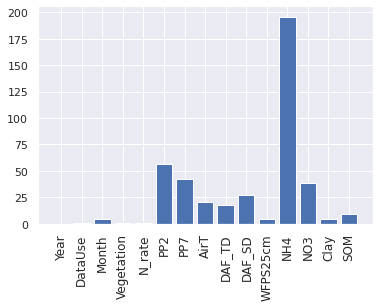

array([0.63583454, 0.56293611, 0.31115141])

In [72]:
X_train_fs, X_test_fs, fs_ = select_features_corr_based(X_train, y_train, X_test, x=7)
fs_score_plot(fs_)

cv = cross_val_score(XGBRegressor(), X_train_fs, y_train, scoring='r2', cv=3, n_jobs=-1)
cv

*With pearson criterion, the model performs fairly better compared to baseline*
<hr>
<hr>

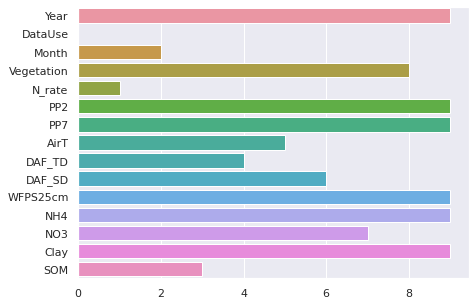

array([0.70472053, 0.46484664, 0.31686472])

In [73]:
X_train_rfe, X_test_rfe, rfe_ = select_features_model_based(XGBRegressor(), X_train, y_train, X_test, n=6)
plt.figure(figsize=(7,5))
sns.barplot(y =X_train.columns, x = max(rfe_.ranking_) - rfe_.ranking_)
plt.show()

cv = cross_val_score(XGBRegressor(), X_train_rfe, y_train, scoring='r2', cv=3, n_jobs=-1)
cv

*With estimator centered approach, the model performs better compared to baseline as well as correlated features*
<hr>
<hr>

In [74]:
print(modelling(X_train_fs, y_train, X_test_fs, y_test, xgb=True, rf=True, dtree=True))
print(modelling(X_train_rfe, y_train, X_test_rfe, y_test, xgb=True, rf=True, dtree=True))

{'xgb': 325.83517856947486, 'rf': 308.5696052967802, 'dtree': 644.5273498198449}
{'xgb': 341.2685261199148, 'rf': 197.43880356848172, 'dtree': 346.5387908690583}


### Feature Transformation

This is the imbalance of Vegetation after Preprocessing:  
1    1184   
2      54   
3      49   
Name: Vegetation

For improved results, we can balance the dataset using Oversampling with SMOTE
**Proceed to Oversample for reducing imbalance**

In [75]:
major = soil_group.drop(["Vegetation"], axis=1)
minor = soil_group["Vegetation"]

counter = Counter(minor)

for k,v in counter.items():
    per = v / len(minor) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=1184 (91.997%)
Class=2, n=54 (4.196%)
Class=3, n=49 (3.807%)


In [76]:
oversample = SMOTE()
major, minor = oversample.fit_resample(major, minor)
# summarize distribution
counter = Counter(minor)
for k,v in counter.items():
    per = v / len(minor) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=1184 (33.333%)
Class=2, n=1184 (33.333%)
Class=3, n=1184 (33.333%)


In [77]:
soil_balanced = pd.concat([major,minor], axis=1)
soil_balanced

Year  DataUse  Month       N2O      N_rate        PP2        PP7  \
0     2002        0      3  0.307500  170.000000   0.000000   0.000000   
1     2002        0      4  0.630000  170.000000  23.876000  25.781000   
2     2002        0      4  0.610000  170.000000   1.016000   6.210300   
3     2002        0      5  3.935000  164.000000   0.000000  39.611300   
4     2002        0      5  1.760000  162.000000   0.000000   3.543300   
...    ...      ...    ...       ...         ...        ...        ...   
3547  2010        0      5  2.302440   87.329488   0.004160  17.488286   
3548  2004        0      8  1.115310   90.000000   0.043999  17.943779   
3549  2013        0      4  0.870263   91.000000   1.700127  50.012800   
3550  2013        0      5  7.441721  106.800000   0.061006   0.061006   
3551  2008        0      4  1.590022   86.459499   0.000000   8.169895   

           AirT      DAF_TD      DAF_SD  WFPS25cm        NH4        NO3  \
0      0.550000  356.000000  312.000000  0.370097   5.350371   3.114477   
1      7.670000  370.000000  326.000000  0.416034   6.377781   4.214812   
2     12.970000  384.000000  340.000000  0.334452   6.940021   4.172479   
3     13.560000    5.000000  361.000000  0.352245   8.441531   9.100344   
4     22.000000   20.000000  376.000000  0.271834   9.735911  21.946054   
...         ...         ...         ...       ...        ...        ...   
3547  22.430748   36.687152   28.931887  0.303145   3.134510   6.362752   
3548  17.346334  322.083884  131.083884  0.362535   4.504884   5.176328   
3549   9.602028  713.072097  673.072097  0.378009   2.684896   5.617312   
3550  19.041536    8.372332   74.172332  0.420990  17.733855  28.419379   
3551  15.505374   31.054491   13.406478  0.371248  11.016006  10.837802   

            Clay       SOM  Vegetation  
0     160.979167  1.578100           1  
1     160.979167  1.578100           1  
2     160.979167  1.578100           1  
3     160.979167  1.578100           1  
4     160.979167  1.578100           1  
...          ...       ...         ...  
3547  160.651412  1.576755           3  
3548  160.979167  1.578100           3  
3549  160.979167  1.578100           3  
3550  141.283333  1.497294           3  
3551  160.979167  1.578100           3  

[3552 rows x 16 columns]

<hr>
<hr>

***Model Testing on Balanced Unscaled dataset***

In [78]:
X = soil_balanced.drop("N2O", axis=1)
y = soil_balanced["N2O"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)



r2 score for base model: 0.675688


<AxesSubplot:>

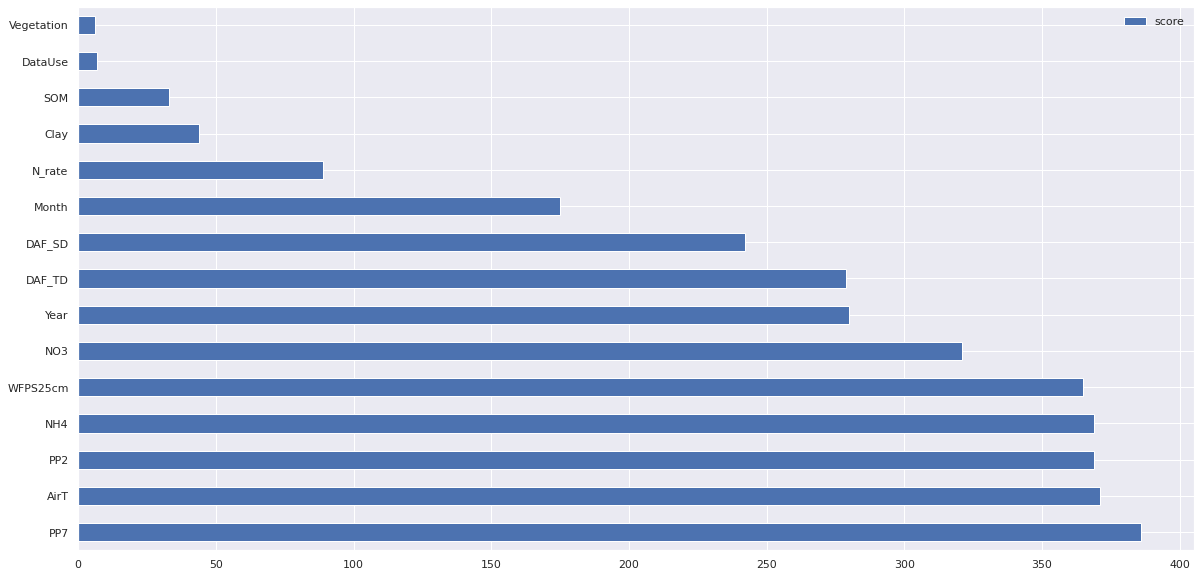

In [79]:
boost = XGBRegressor()
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)
print("r2 score for base model: %f" % r2_score(y_test, y_pred))

feature_important = boost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', figsize = (20,10))

The model score, and ***Feature Importance*** drastically improved after balancing the dataset.

*Kindly note that the same results can be obtained with direct **feature scaling** on all the attributes (except target variable)*

In [80]:
modelling(X_train, y_train, X_test, y_test, xgb=True, rf=True, dtree=True)

{'xgb': 60.68411590233046, 'rf': 53.81443698344635, 'dtree': 65.98640472905228}

***Extracting main selected Features:***

In [81]:
feats = data.index[:10].to_list()
feats

['PP7',
 'AirT',
 'PP2',
 'NH4',
 'WFPS25cm',
 'NO3',
 'Year',
 'DAF_TD',
 'DAF_SD',
 'Month']

# Hyperparameter Tuning

Using XGBRegressor with selected features for tuning

In [87]:
X_train_sel = X_train[feats]
x_test_sel = X_test[feats]

cv = RepeatedKFold(n_splits= 7, n_repeats = 1, random_state = 1)

grid_params_xgb = [{ 'n_estimators': [100, 200],
                   'model__subsample': [i/10 for i in range(9,11)]
                    }]

XGB = GridSearchCV(estimator=boost,
            param_grid=grid_params_xgb,
            scoring='neg_mean_squared_error',
            cv=cv, 
            n_jobs= -1,
            verbose=2)


XGB.fit(X_train_sel, y_train)


Fitting 7 folds for each of 4 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed: 16.4min finished


[12:12:18] WARNING: ../src/learner.cc:576: 
Parameters: { "model__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=7, random_state=1),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=4,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
        

[CV] model__subsample=0.9, n_estimators=100 ..........................
[11:55:55] WARNING: ../src/learner.cc:576: 
Parameters: { "model__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] ........... model__subsample=0.9, n_estimators=100, total= 1.6min
[CV] model__subsample=0.9, n_estimators=200 ..........................
[11:57:33] WARNING: ../src/learner.cc:576: 
Parameters: { "model__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] ........... model__subsample=0.9, n_estimators=2

In [88]:
print('Best MAE: %.3f' % XGB.best_score_) # model__max_depth=12, model__min_child_weight=8, model__subsample=1.0, n_estimators=200
boost_final = XGB.best_estimator_

Best MAE: -45.992


<hr>
<hr>

The following results are observed after this stage.

The model score has improved from **0.27 to 0.71**. The results may vary according to *train-test samples.*
**But the approach shown will yield better performing model**

In [91]:
y_hat = boost_final.predict(X_test[feats])
print(f'Training score : {XGB.score(X_train[feats],y_train)}')

# print()
print('r2 score:', r2_score(y_test, y_hat))
print('MAE:', mean_absolute_error(y_test, y_hat))
print('MSE:', mean_squared_error(y_test, y_hat))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat)))

Training score : -0.016191268266241687
r2 score: 0.6926764299548599
MAE: 2.0017611702846274
MSE: 57.50530595178511
RMSE: 7.5832253000807714


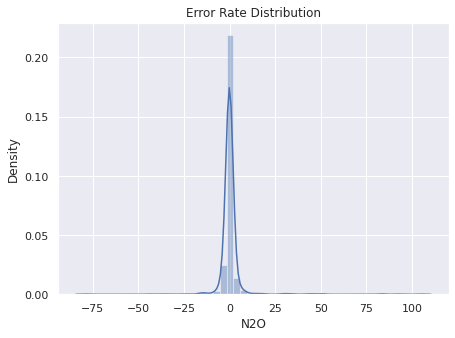

In [92]:
plt.figure(figsize = (7,5))
sns.set()
sns.distplot(y_test - y_hat)
plt.title("Error Rate Distribution");

# Saving the best estimator

In [93]:
import joblib

with open('./boost_final.pkl.compressed', 'wb') as m:
    joblib.dump(boost_final, m, compress=3)
    
    
    
# with open('./boost_final.pkl.compressed', 'rb') as m:
#     a = joblib.load(m)
# a

# Explainable AI

In [95]:
try:
    import shap
except:
    !pip install --quiet shap==0.40.0
    import shap

In [98]:
shap.initjs()
X_test_sample = X_test[feats].sample(850)
model = boost_final


# shap values
shap_values = shap.TreeExplainer(model).shap_values(X_test_sample)

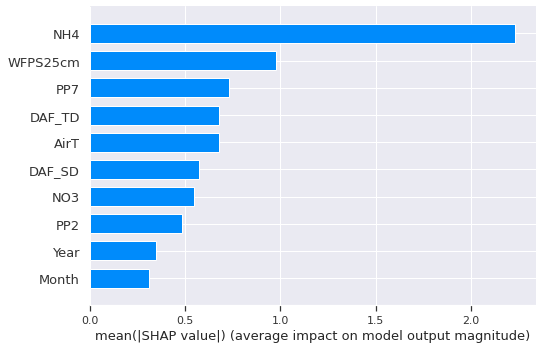

In [100]:
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")

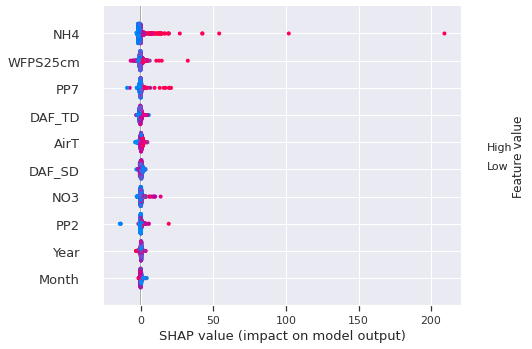

In [101]:
shap.summary_plot(shap_values, X_test_sample)

In [102]:
print(y_hat[60])
shap.force_plot(shap.TreeExplainer(model).expected_value, shap_values[60], X_test_sample.iloc[60])

1.5340476


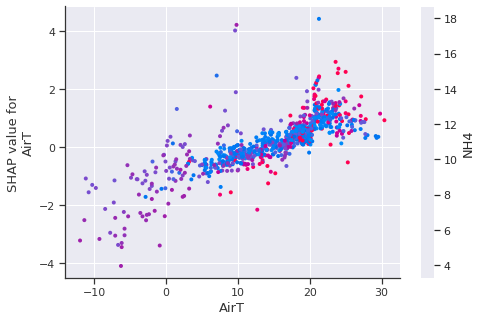

In [103]:
shap.dependence_plot('AirT', shap_values, X_test_sample)

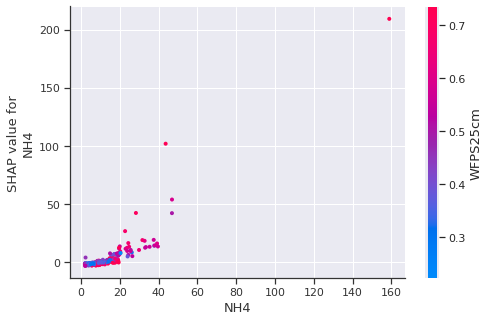

In [104]:
shap.dependence_plot('NH4', shap_values, X_test_sample)

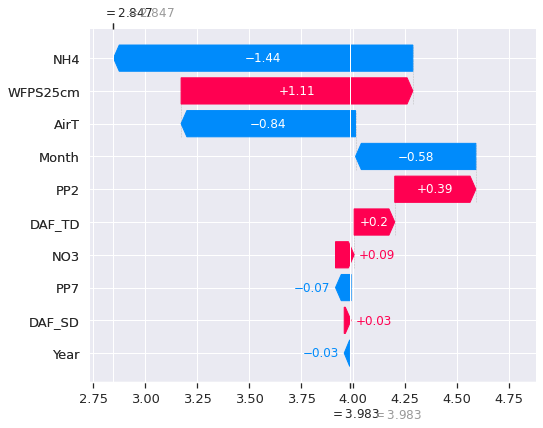

Year          2006.000000
DataUse          0.000000
Month            4.000000
N_rate           0.000000
PP2              0.000000
PP7              1.550371
AirT            14.792742
DAF_TD         357.543924
DAF_SD         317.543924
WFPS25cm         0.345124
NH4              7.475905
NO3              7.459748
Clay           159.637250
SOM              1.540953
Vegetation       2.000000
Name: 1365, dtype: float64


In [106]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=X_test_sample.columns.tolist()
                                      )

print(X_test.iloc[row])

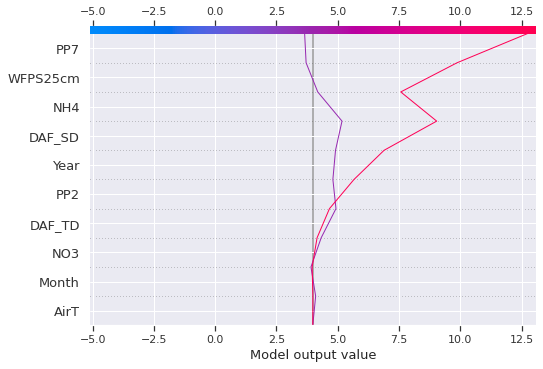

In [108]:
x=40
shap.decision_plot(shap.TreeExplainer(model).expected_value[0], 
                   shap_values[x:x+2], 
                   feature_names=X_test_sample.columns.tolist())

#### 1. What is the result of grouping vegetation/replication chamber?
NH4 (Ammonium) has a direct relation with the rate of nitrigran flux (N_flux). Since the highest sown crop is Corn, the flux rate for those chambers are high, due to high ammonium rate of Corn crops. Merging same chambers grounds the level of nitrogen, and removes bias from the chamber class with the final prediction value.


#### 2. What is the aim of the notebook (project)?
Experiment values in agriculture is tricky to analyse, given that the authenticity can dissapear at any stage of preprocessing. The notebook explores all sides of data exploration that can save the data's reliance for modeling purposes.

<hr>

**Ref:** [Research Paper](https://www.researchgate.net/publication/347608654_Machine_learning_improves_predictions_of_agricultural_nitrous_oxide_N_2_O_emissions_from_intensively_managed_cropping_systems?enrichId=rgreq-4779e51bb62e061cd36d1895c75a87a8-XXX&enrichSource=Y292ZXJQYWdlOzM0NzYwODY1NDtBUzo5ODEwNjQzMDY2Nzk4MDlAMTYxMDkxNTM2Njk1Ng%3D%3D&el=1_x_3&_esc=publicationCoverPdf)  
<hr>